<center><b><H1> ASSIGNMENT 2 EE679 </H1></b> </center>
<center><b><H2> Name: VINIT AWALE </H2></b> </center>
<center><b><H2> Roll No. : 18D070067 </H2></b> </center>

<H1> Question </H1>
Given the speech segment (aa.wav) extracted from the word “pani” in “machali.wav” (male voice), sampled at 8 kHz, do the following.  Report/discuss
your observations at each step.  


<H1> IMPORTS </H1>

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
## Let us first read the given audio file
import scipy.io.wavfile as wav

sampling_rate, aa = wav.read('aa.wav')

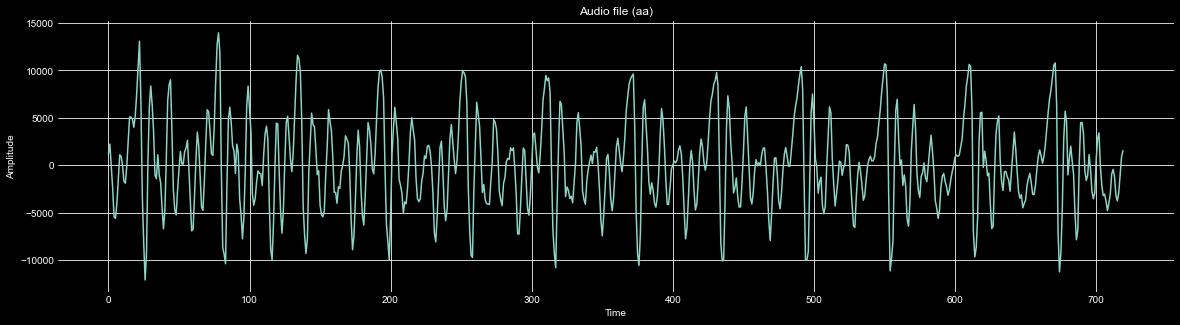

In [40]:
## Visualize the audio file
plt.figure(figsize=(20,5))
plt.plot(aa)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Audio file (aa)')
plt.show()

In [41]:
sampling_rate

8000

Hence, as mentioned in the question the sampling rate of the audio file is 8 kHz

# Part 1

## Apply pre-emphasis to the signal. 

Consider the following pre-emphasis filter 
$$ H(z) = 1 - \alpha z^{-1} $$

where $\alpha$ is a constant. For this assignment let $\alpha$ be 0.95. Hence, the filter is given by
$$ H(z) = 1 - 0.95 z^{-1} $$
$$ \implies \frac{Y(z)}{X(z)} = 1 - 0.95 z^{-1} $$

Where, Y(z) is the z-transform of the output signal and X(z) is the z-transform of the input signal to the filter.

$$ \implies Y(z) = X(z) - 0.95 X(z) z^{-1} $$
Hence, after taking inverse z transform, we get
$$ \implies y[n] = x[n] - 0.95 x[n - 1] $$

Now, let us find the output when the "aa" signal is passed through the pre-emphasis filter.

In [42]:
pre_emphasis_aa = np.zeros(len(aa))

pre_emphasis_aa[0] = aa[0]

for i in range(1, len(aa)):
    pre_emphasis_aa[i] = aa[i] - 0.95 * aa[i-1]
    

### Visualization of the pre-emphasized signal

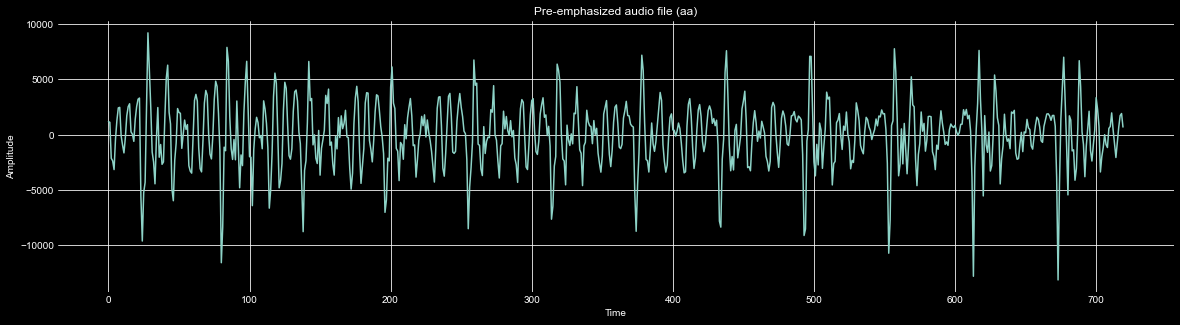

In [43]:
plt.figure(figsize=(20,5))
plt.plot(pre_emphasis_aa)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Pre-emphasized audio file (aa)')
plt.show()

### Combined Plot

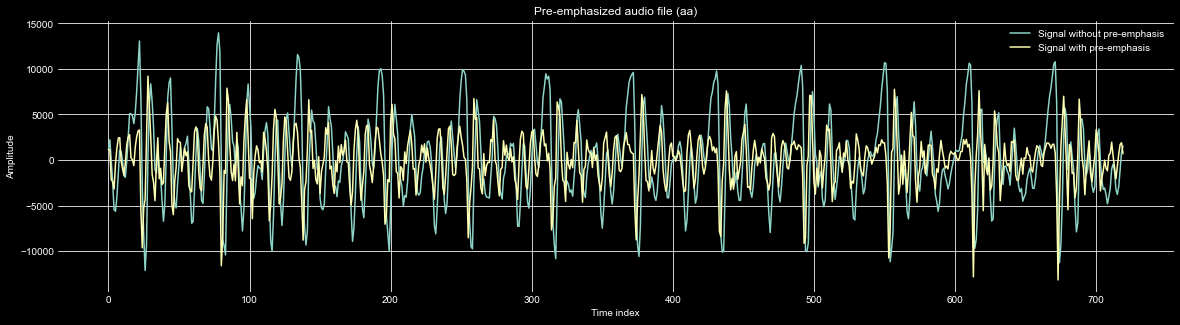

In [44]:
plt.figure(figsize=(20,5))
plt.plot(aa , label = "Signal without pre-emphasis")
plt.plot(pre_emphasis_aa, label = "Signal with pre-emphasis")
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.title('Pre-emphasized audio file (aa)')
plt.legend()
plt.show()

### Writing the output of pre_emphasis_aa to a file

In [45]:
from scipy.io.wavfile import write

pre_emphasis_aa_sound = np.int16(pre_emphasis_aa/np.max(np.abs(pre_emphasis_aa)) * 32767)
write('pre_emphasis_aa.wav', sampling_rate, pre_emphasis_aa_sound)

# Part 2

## Compute and plot the narrowband magnitude spectrum slice using a Hamming window of duration = 30 ms on a segment near the centre of the given audio file.


In [46]:
## Hamming window of duration 30 ms
hamming_window = np.hamming(30e-3*sampling_rate)

## Append zeros on both sides of Hamming window to make it of the same lenght as the pre-emphasized audio file
hamming_window = np.pad(hamming_window, ((len(pre_emphasis_aa)-len(hamming_window))//2 , (len(pre_emphasis_aa)-len(hamming_window))//2), 'constant')

## Window the pre-emphasized aa signal
windowed_aa = pre_emphasis_aa * hamming_window

## Find the FFT of the windowed aa signal
ft_aa = np.fft.fft(windowed_aa)
ft_aa = np.abs(ft_aa)
f_aa = np.fft.fftfreq(len(ft_aa), 1/sampling_rate)

### Visualization of the narrowband magnitude spectrum slice

Text(0.5, 1.0, 'DFT of pre-emphasized audio file (aa)')

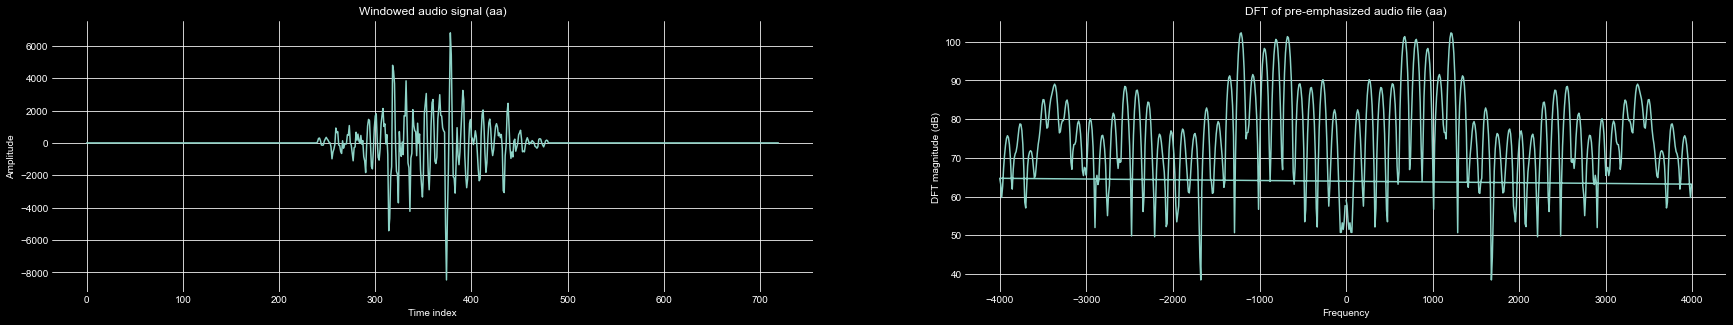

In [47]:
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(windowed_aa)
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.title('Windowed audio signal (aa)')

plt.subplot(1,2,2)
plt.plot(f_aa, 20*np.log10(ft_aa))
plt.xlabel('Frequency')
plt.ylabel('DFT magnitude (dB)')
plt.title('DFT of pre-emphasized audio file (aa)')


<H3> Comments: </H3>
The signal with windowed signal with pre-emphasis applied is shown on left and its Fourier magnitude spectrum is shown on right in the above figure

# Part 3

## With the same 30 ms segment of part 2, compute the autocorrelation coefficients required for LPC calculation at various p = 2,4,6,8,10.  Use the Levinson-Durbin recursion to compute the LP coefficients from the autocorrelation coefficients. Plot error signal energy (i.e. square of gain) vs p. 

In [48]:
## Let us compute the Auto-correlation of the windowed aa signal for lags of 0 to 100 index values
## However, we need only the first 10 coefficients for LPC calculation
def autocorrelation_func(signal, lags):
    autocorrelation_ = np.zeros(lags)
    for i in range(lags):
        autocorrelation_[i] = np.sum(signal[i:]*signal[:len(signal)-i])

    return autocorrelation_


autocorrelation = autocorrelation_func(windowed_aa, 100)

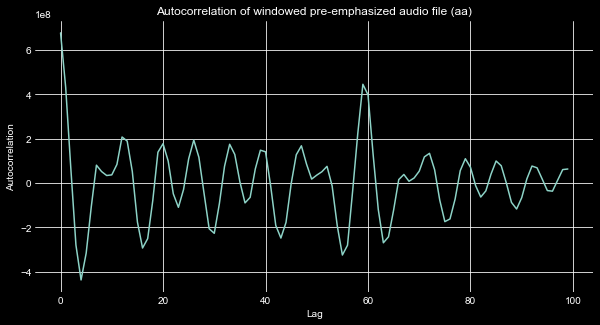

In [49]:
plt.figure(figsize=(10,5))
plt.plot(autocorrelation)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of windowed pre-emphasized audio file (aa)')
plt.show()

In [50]:
## Let us find the LP coefficients
## We will use the Levinson-Durbin algorithm
## We will use the first 10 coefficients


def Levinson_Durbin(autocorrelation, order):
    """Function to find the LP coefficients using the Levinson-Durbin algorithm
       Note: This function returns the LP coefficients such that the coefficient at index 0 is 0 and should be ignored

    Args:
        autocorrelation (ndarray): Autocorrelation of the signal
        order (int): Order of the LP filter

    Returns:
        ndarray: LP coefficients such that the coefficient at index 0 is 0 and should be ignored
    """
    ## Initialize the LPC coefficients
    lp_coefficients = np.zeros((order+1, order+1))

    ## Initialize the prediction error
    prediction_error = np.zeros(order+1)

    ## Initialize the reflection coefficients
    reflection_coefficients = np.zeros(order+1)

    prediction_error[0] = autocorrelation[0]

    # for i = 1
    reflection_coefficients[1] = autocorrelation[1]/prediction_error[0]
    lp_coefficients[1][1] = reflection_coefficients[1]

    prediction_error[1] = (1 - reflection_coefficients[1]**2)*prediction_error[0]

    # for i = 2 to order

    for i in range(2, order+1):
        summation = 0
        for j in range(1, i):
            summation += lp_coefficients[i-1][j]*autocorrelation[i-j]
        
        reflection_coefficients[i] = (autocorrelation[i] - summation)/prediction_error[i-1]

        lp_coefficients[i][i] = reflection_coefficients[i]

        for j in range(1, i):
            lp_coefficients[i][j] = lp_coefficients[i-1][j] - reflection_coefficients[i]*lp_coefficients[i-1][i-j]

        prediction_error[i] = (1 - reflection_coefficients[i]**2)*prediction_error[i-1]

    return lp_coefficients,prediction_error

lp_coefficients , error_energy = Levinson_Durbin(autocorrelation, 10)

gain = np.sqrt(error_energy)                # Gain of the LP filter which is the square root of the prediction error

In [51]:
orders = [2,4,6,8,10]

for order in orders:
    print("The coefficients for p="+str(order)+" are:", str(lp_coefficients[order][1:order+1]))

The coefficients for p=2 are: [ 0.96454776 -0.51474629]
The coefficients for p=4 are: [ 0.68322148 -0.13507646 -0.28905557 -0.16557719]
The coefficients for p=6 are: [ 0.73630801 -0.14236591 -0.31958052 -0.28524925  0.28348265 -0.18881888]
The coefficients for p=8 are: [ 0.5881573  -0.11510746 -0.22581153 -0.54813899  0.03861646 -0.09802675
  0.21389618 -0.58065459]
The coefficients for p=10 are: [ 0.71103761 -0.06174574 -0.2354676  -0.55416698  0.16613212  0.05255368
  0.2772599  -0.72267503  0.17179372  0.15318719]


### Plot of the Error Energy Function

The error energy function is the sum of the squared prediction errors for each lag. Although I have calculated the error energy in the implementation of the Levinson-Durbin recursion, I will calculate it again here from the first principles i.e. using the equation 
$$ Error \: energy = r[0] - sum(a_k \times r[k]) $$

where $r[k]$ is the autocorrelation coefficient at lag $k$ and $a_k$ is the coefficient of the $k$th order LPC filter.

Text(0.5, 1.0, 'Error energy vs order')

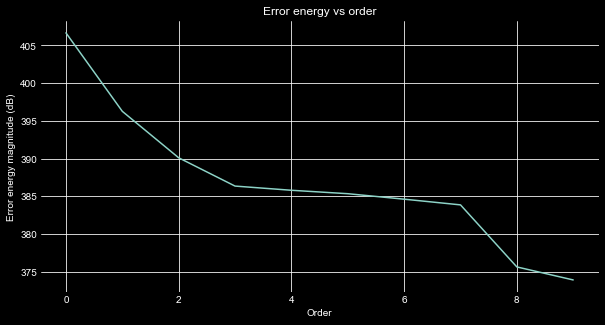

In [52]:
error_energy = np.zeros(10)
error_energy[0] = autocorrelation[0]

for i in range(1,10):
    error_energy[i] = autocorrelation[0] - np.dot(lp_coefficients[i][1:i+1].reshape(-1),autocorrelation[1:i+1])

plt.figure(figsize=(10,5))
plt.plot(20*np.log(error_energy))
plt.xlabel('Order')
plt.ylabel('Error energy magnitude (dB)')
plt.title('Error energy vs order')    

<H3> Comment: </H3>
We can easily see from the plot that the error energy function is decreasing with increasing order of the LPC filter.

# Part 4

## Show the pole-zero plots of the estimated all-pole filter for p=6,10; comment

In [53]:
from scipy import signal
plt.style.use('seaborn-darkgrid')
def poleZeroPlot(b,a,order):
    poles = np.zeros(len(a))
    poles[0]=1
    poles[1:len(a)] = -a[1:len(a)]
    b=[b]
    z, p, k = signal.tf2zpk(b, poles)
    p = p[p!=0]
    
    fig = plt.figure(figsize=(5,5))
    ax=fig.add_subplot(1, 1, 1)
    
    plt.plot(np.real(z), np.imag(z), 'ob')
    plt.plot(np.real(p), np.imag(p), 'sr',markersize=5,fillstyle="full")
    circ = plt.Circle((0, 0), radius=1,facecolor='None',color='black', ls='solid', alpha=0.1)
    ax.add_patch(circ)
    plt.axhline(0,color='black',alpha=0.4)
    plt.axvline(0,color='black',alpha=0.4)
    plt.ylim((-2.0, 2.0))
    plt.xlim((-2.0,2.0))
    plt.legend(['Zeros', 'Poles'])
    plt.ylabel('Real')
    plt.xlabel('Imaginary')
    plt.title('Pole-Zero Plot for LP filter with order '+str(order))
    plt.grid()

    plt.show()

### For order = 6

C:\Users\Vinit\AppData\Local\Temp/ipykernel_7004/3354072316.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circ = plt.Circle((0, 0), radius=1,facecolor='None',color='black', ls='solid', alpha=0.1)


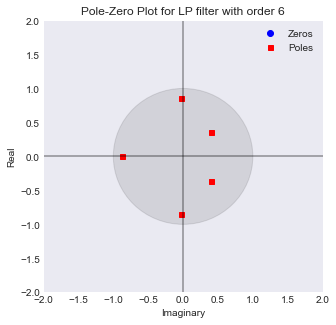

In [54]:
poleZeroPlot(gain[6],lp_coefficients[6][1:],6)

### For order = 10

C:\Users\Vinit\AppData\Local\Temp/ipykernel_7004/3354072316.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circ = plt.Circle((0, 0), radius=1,facecolor='None',color='black', ls='solid', alpha=0.1)


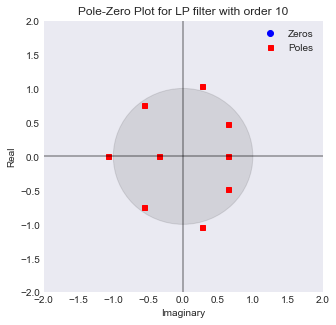

In [55]:
poleZeroPlot(gain[10],lp_coefficients[10][1:],10)

In [56]:
plt.style.use('dark_background')

# Part 5

## Compute the gain and plot the LPC spectrum magnitude (i.e. the dB magnitude frequency response of the estimated all-pole filter) for each order "p".  Comment on the characteristics of the spectral envelope estimates. Comment on their shapes with reference to the short-time magnitude spectrum computed in part 2

In [57]:
gain                # We have already computed the gain for the LP filter

array([26014.46894783, 20058.51601538, 17197.01933469, 15657.81321431,
       15441.68580839, 15267.4599599 , 14992.82783309, 14712.31310423,
       11978.02988378, 11472.46446395, 11337.05712869])

In [58]:
from scipy.signal import freqz

def plot_spectrum(order,lp_coefficients_,gain_):
    for i in range(1,order+1):
        poles = np.zeros_like(lp_coefficients_[i])
        poles[0] = 1
        poles[1:] = -lp_coefficients_[i][1:] 
        w,h = freqz(gain_[i],poles)

        plt.figure(figsize=(10,5))
        plt.title("LPC spectrum for poles="+str(i))
        plt.plot(f_aa, 20*np.log10(np.abs(ft_aa)), label = 'Original Spectrum')
        plt.plot(w*sampling_rate/(2*np.pi),20*np.log10(abs(h)),linewidth=2, label = "LPC Estimate Spectrum")
        plt.ylabel("Fourier Spectrum Magnitude(dB)")
        plt.xlabel("Frequency")
        plt.xlim(xmin=0)
        plt.grid("True")
        plt.show()

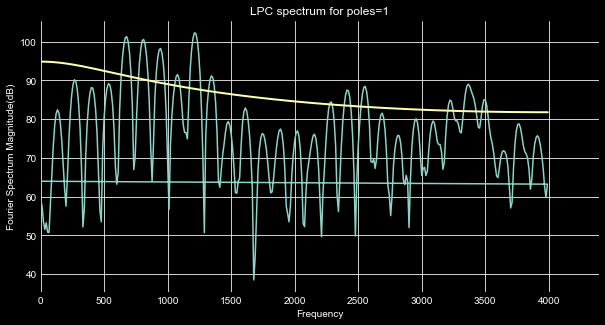

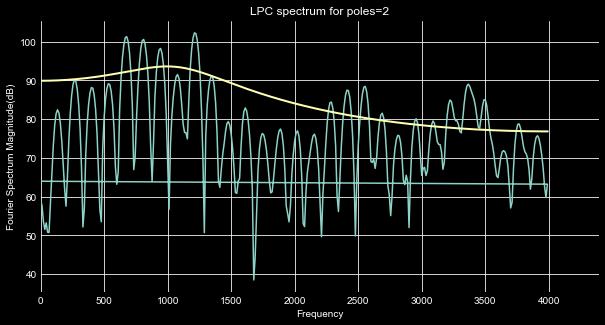

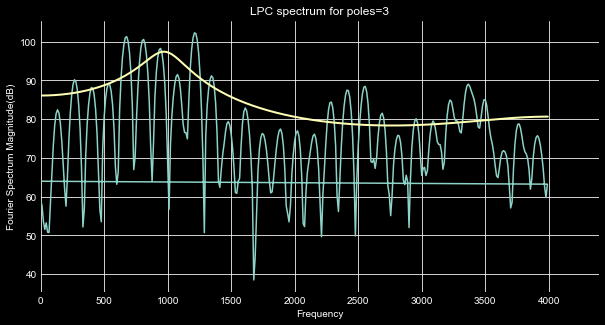

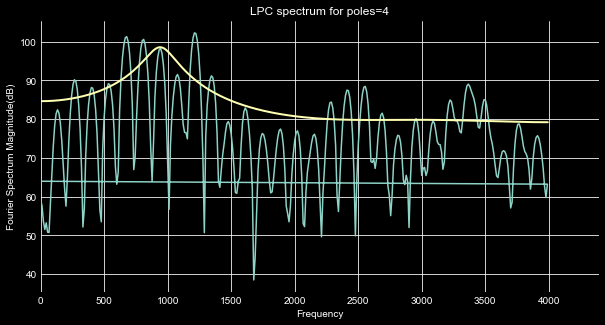

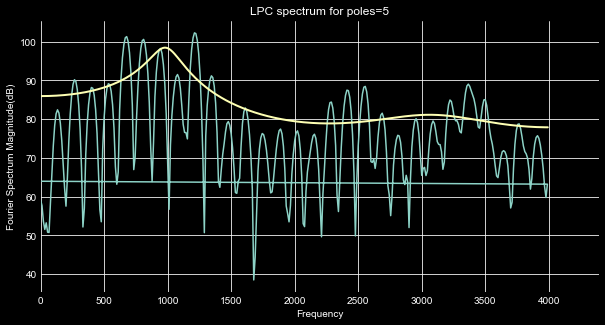

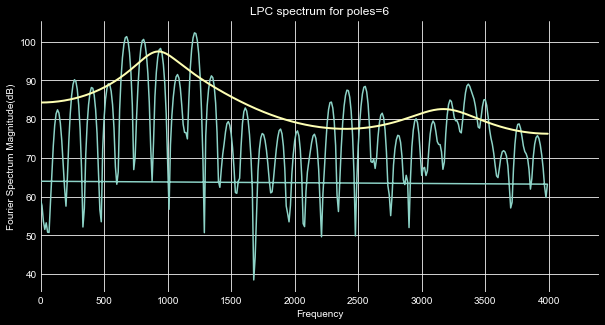

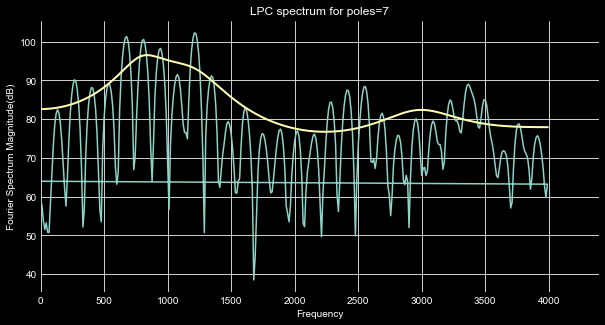

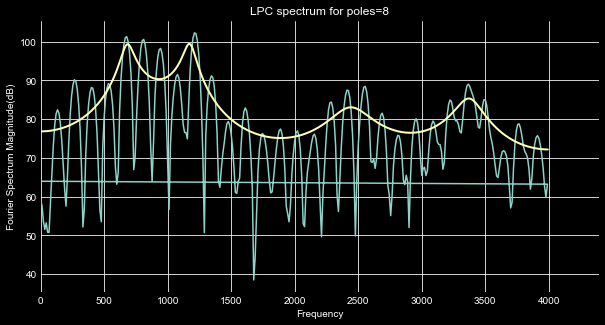

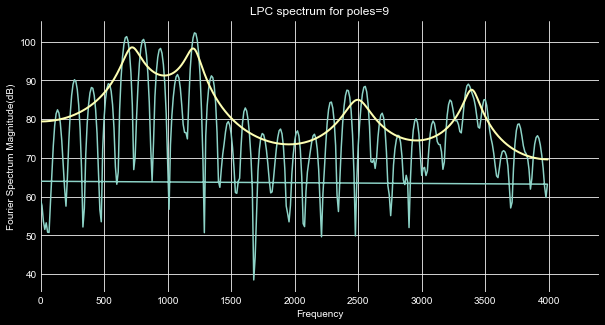

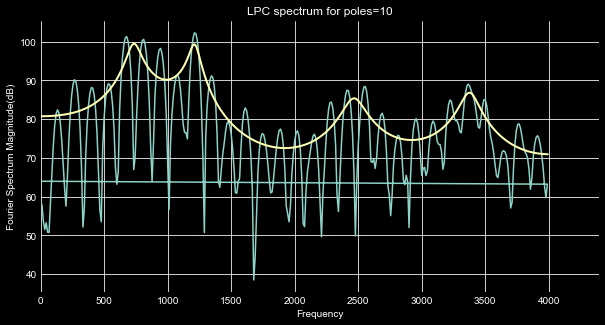

In [59]:
order = 10

plot_spectrum(order,lp_coefficients,gain)

### Commments: 

<H3> Characteristics of the spectral envelope estimates </H3>







# Part 6

## Based on the 10th-order LP coefficients, carry out the inverse filtering of the /a/ vowel segment to obtain the residual error signal. Can you measure the pitch period of the voiced sound from the residual waveform? Use the acf to detect the pitch. Compare the acf plots of the original speech and residual signals. 

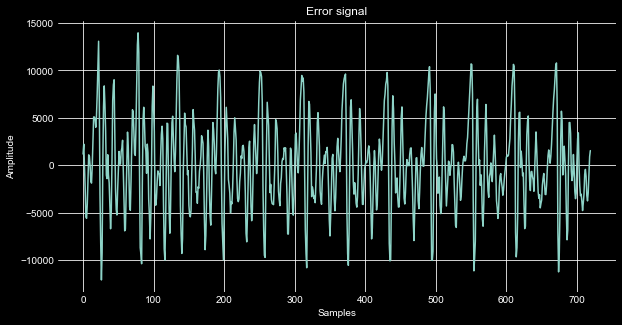

In [61]:
lp_10 = lp_coefficients[10][1:]

# Inverse filtering using the LPC coefficients for windowed_aa signal

estimated_aa = np.zeros(len(windowed_aa))

for i in range(len(estimated_aa)):
    summation = 0
    for j in range(0,order):
        # ignore the negative indices
        if i-j >= 0:
            summation += lp_10[j]*estimated_aa[i-j]
    
    estimated_aa[i] = summation

error_signal = aa - estimated_aa 


plt.figure(figsize=(10,5))
plt.plot(error_signal)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Error signal')
plt.show()
